In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [4]:
import tensorflow as tf
import numpy as np
tf.__version__
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Apr 24 20:08:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    35W / 250W |    353MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import numpy as np
import argparse
import cv2
import os
from imutils import paths

Using TensorFlow backend.


In [ ]:
x_train=np.load('My Drive/Colab Notebooks/215-FP_Dataset/numpy5/x_train.npy')

In [ ]:
y_train=np.load('My Drive/Colab Notebooks/215-FP_Dataset/numpy5/y_train.npy')

In [ ]:
x_valid=np.load('My Drive/Colab Notebooks/215-FP_Dataset/numpy5/x_valid.npy')

In [ ]:
y_valid=np.load('My Drive/Colab Notebooks/215-FP_Dataset/numpy5/y_valid.npy')

In [12]:
y_valid

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [ ]:
y_train2=y_train
y_valid2=y_valid

In [ ]:
y_train2=np.argmax(y_train,axis=1)
y_valid2=np.argmax(y_valid,axis=1)

In [16]:
y_train2[:50]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 1])

In [17]:
y_valid2[:50]

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1])

In [18]:
summation1=0
for i in range(len(x_valid)):
    if y_valid2[i]==0:
        summation1=summation1+1
summation1

1019

In [19]:
summation2=0
for i in range(len(x_train)):
    if y_train2[i]==0:
        summation2=summation2+1
summation2

4074

In [ ]:
#y_train=y_train2
y_train=((y_train)/255.).astype('float16')

In [ ]:
#y_valid=y_valid2
y_valid=((y_valid)/255.).astype('float16')

In [ ]:
INIT_LR = 1e-3
EPOCHS = 100
BS = 128

In [ ]:
trainX=x_train
trainY=y_train
testX=x_valid
testY=y_valid

In [ ]:

# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = ResNet152V2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(128, 128, 3)))

In [ ]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [37]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss='binary_crossentropy', optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/100
47/47 [==============================] - 27s 569ms/step - loss: 0.7581 - accuracy: 0.5449 - val_loss: 0.6932 - val_accuracy: 0.5753
Epoch 2/100
47/47 [==============================] - 24s 515ms/step - loss: 0.6933 - accuracy: 0.6112 - val_loss: 0.6932 - val_accuracy: 0.6311
Epoch 3/100
47/47 [==============================] - 24s 507ms/step - loss: 0.6932 - accuracy: 0.6295 - val_loss: 0.6932 - val_accuracy: 0.6423
Epoch 4/100
47/47 [==============================] - 24s 507ms/step - loss: 0.6932 - accuracy: 0.6500 - val_loss: 0.6932 - val_accuracy: 0.6523
Epoch 5/100
47/47 [==============================] - 24s 506ms/step - loss: 0.6932 - accuracy: 0.6508 - val_loss: 0.6932 - val_accuracy: 0.6530
Epoch 6/100
47/47 [==============================] - 24s 506ms/step - loss: 0.6932 - accuracy: 0.6651 - val_loss: 0.6932 - val_accuracy: 0.6549
Epoch 7/100
47/47 [==============================] - 24s 504ms/step - loss: 0.6932 - a

In [40]:
lbclasses=['covid','normal']
lbclasses

['covid', 'normal']

In [41]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lbclasses))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       0.97      1.00      0.98      1019
      normal       1.00      0.93      0.97       488

    accuracy                           0.98      1507
   macro avg       0.98      0.97      0.97      1507
weighted avg       0.98      0.98      0.98      1507

[[1018    1]
 [  32  456]]
acc: 0.9781
sensitivity: 0.9990
specificity: 0.9344


[INFO] saving COVID-19 detector model...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: My Drive/Colab Notebooks/215-FP_Dataset/assets


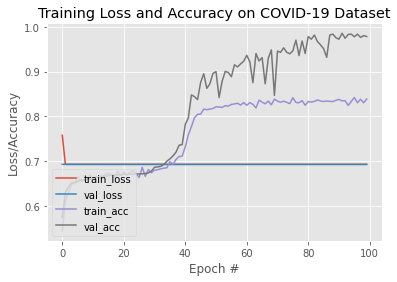

In [45]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('My Drive/Colab Notebooks/215-FP_Dataset/')

# serialize the model to disk
print("[INFO] saving COVID-19 detector model...")
model.save('My Drive/Colab Notebooks/215-FP_Dataset/')